# Natural Language Processing - Consumer Complaint in bank sector

## Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

In [1]:
import os
import re
# Ignore warnings
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from IPython.display import display
from scipy import stats
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from spacy.cli import download
from textblob import TextBlob
from wordcloud import WordCloud

from narrative_to_vec import add_column_average_genre_vector, tokenize_column

warnings.filterwarnings('ignore')

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
## load spacy language model or download it if not available
try:
    # Try to load the language model
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model loaded successfully.")
except OSError:
    # If the model is not available, download it using spacy.cli.download
    print("Model not found. Downloading...")
    download("en_core_web_sm")
    
    # After downloading, try loading again
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model downloaded and loaded successfully.")

Model loaded successfully.


## 3 Feature Engineering

As noted in the previous section, we decided to use a smaller subset of the original data set which is used for all sections from now on.

In [3]:
# read in small dataset
data_path = os.path.join("data", "small.zip")
data = pd.read_csv(data_path)

In [4]:
# lemmatize text 
### depending on system, changing batch size could speed up the process (I think :) )
# process text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in spacy_nlp.pipe(data["narrative_prep"], batch_size=1000, n_process=-1): # runs in parallel (cpu)
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["text_lemma"] = lemma_text_list

In [5]:
# generate counts for words, characters, and sentences as derived features
data['word_count'] = data['narrative'].apply(lambda x: len(x.split()))
data['char_count'] = data['narrative'].apply(lambda x: len(x))
data['sentence_count'] = data['narrative'].apply(lambda x: len(x.split('.')))
data[['narrative', 'word_count', 'char_count', 'sentence_count']].head()

,narrative,word_count,char_count,sentence_count
0,used third party company book vacation package...,64,485,1
1,company u bank reliacard issue account locked ...,66,421,1
2,victim identity fraud personal financial infor...,91,696,1
3,browsing online site invited apply credit card...,70,496,1
4,made payment credit card balance resulting cre...,20,143,1


 ### TF-IDF
Extracting key text features using TF-IDF

In [6]:
# initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data['narrative_prep'])

# convert sparse matrix to df with named features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
display(tfidf_df.head())

,account,bank,called,card,company,credit,day,debt,information,letter,loan,money,month,payment,received,report,said,sent,time,told
0,0.000000,0.371500,0.000000,0.000000,0.904632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.208876,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.228969,0.515305,0.000000,0.000000,0.167308,0.000000,0.168152,0.0,0.172351,0.0,0.0,0.193154,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.747498,0.000000
2,0.117642,0.706022,0.177973,0.369959,0.000000,0.377729,0.000000,0.0,0.354209,0.0,0.0,0.000000,0.0,0.000000,0.0,0.165549,0.0,0.000000,0.153623,0.000000
3,0.000000,0.232403,0.000000,0.852465,0.000000,0.414461,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.217977,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.598907,0.000000,0.407657,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.549107,0.0,0.000000,0.0,0.298447,0.000000,0.290754


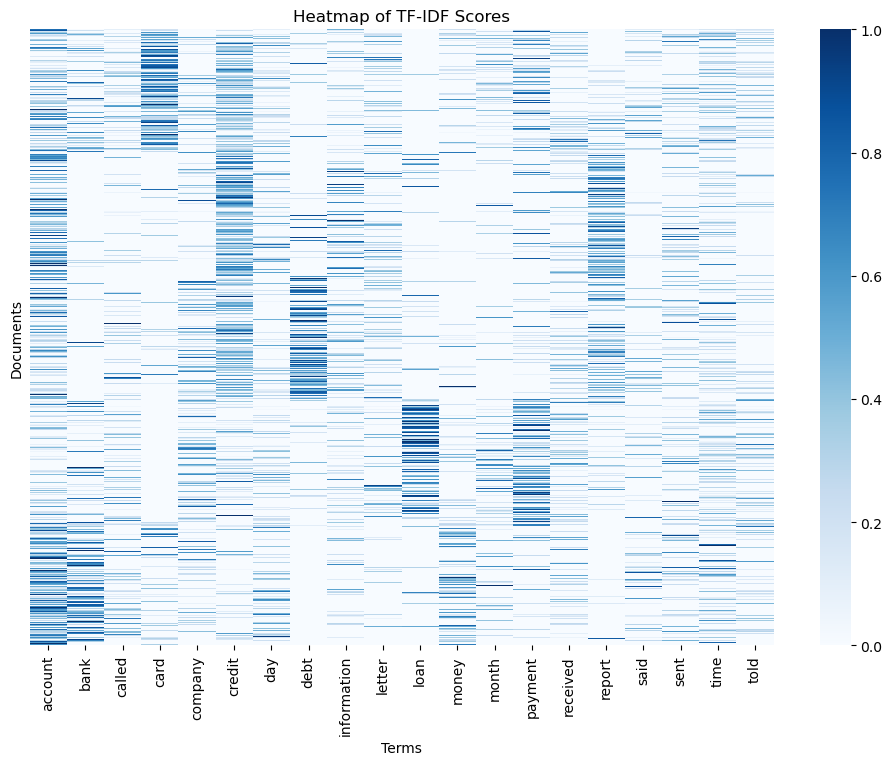

In [7]:
# visualize tfidf scores as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='Blues', yticklabels=False)
plt.title('Heatmap of TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

The heatmap shows how the TF-IDF scores are distributed across different narratives (documents).

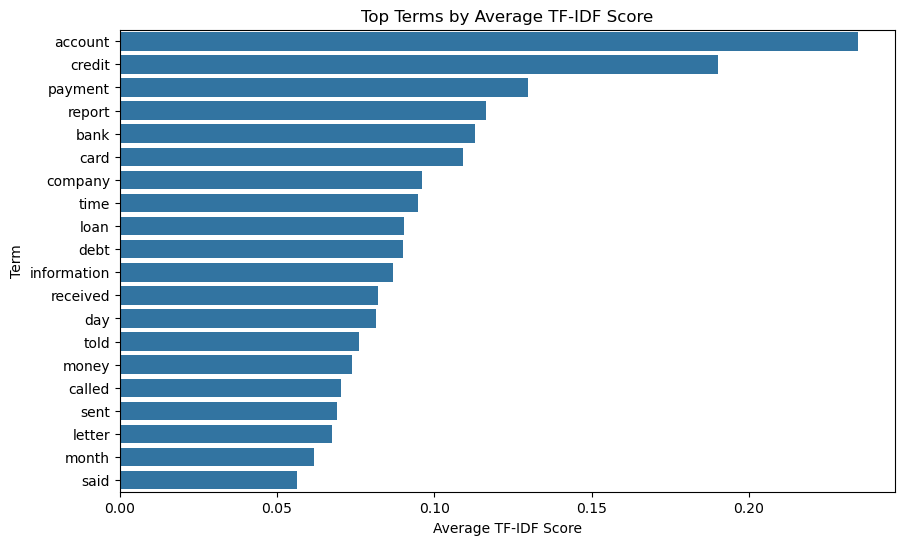

In [8]:
# inspect the average tfidf score over all documents
# calculate mean score
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# plot a barchart 
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index)
plt.title('Top Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

#### Top words by TF-IDF score by products:

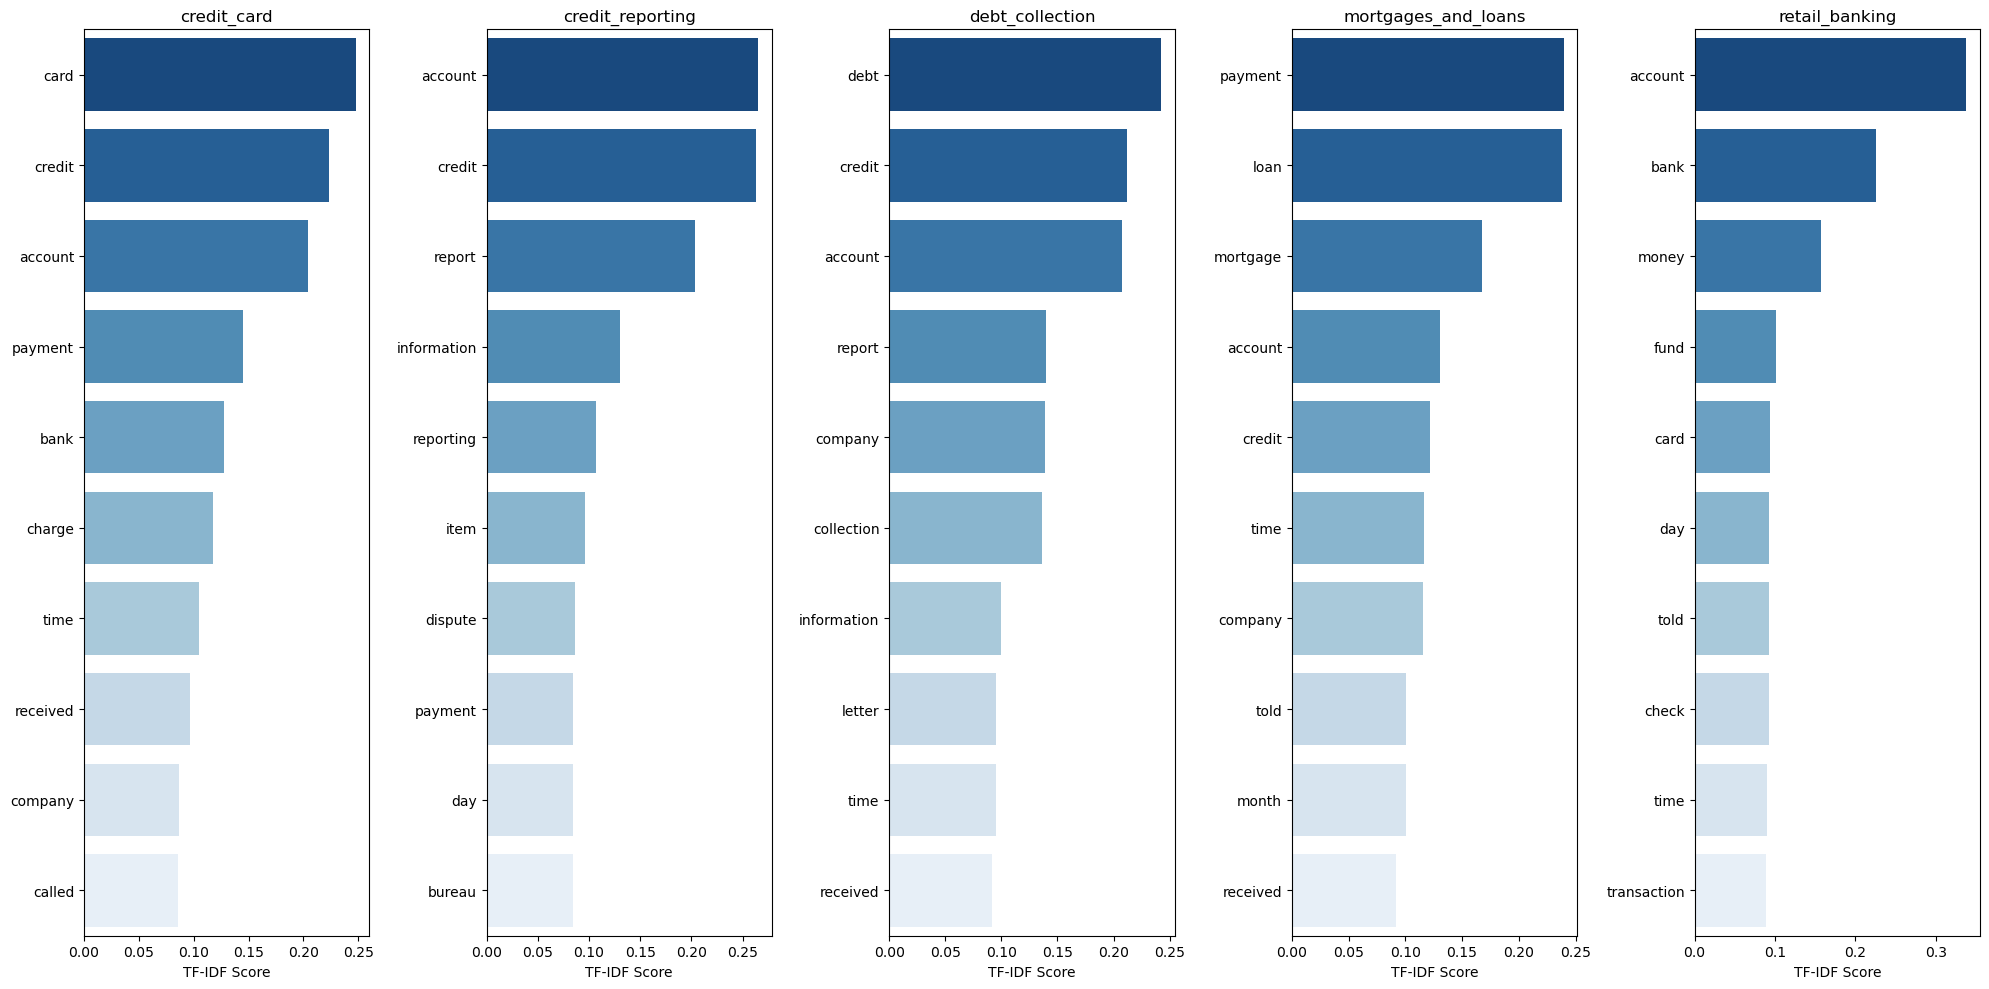

In [9]:
products = data['product'].unique()

# Initialize a TF-IDF vectorizer
#tfidf = TfidfVectorizer(max_features=20)

# show a subplot for each product
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# plot barchart for each product
for i, product in enumerate(products):
    # filter on current product
    product_data = data[data['product'] == product]
    
    # apply tfidf vectorizer
    tfidf_matrix = tfidf.fit_transform(product_data['narrative_prep'])
    
    # convert sparse matrix to df with named features
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # compute mean score
    tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
    
    # plot top 10 words only
    top_words = tfidf_mean.head(10)
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i], palette = 'Blues_r')
    axes[i].set_title(f'{product}')
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

# adjust padding
plt.tight_layout()
plt.show()

#### Sentiment-Analyse: 
Conducting sentiment analysis to find out whether the text is negative, neutral or positive.

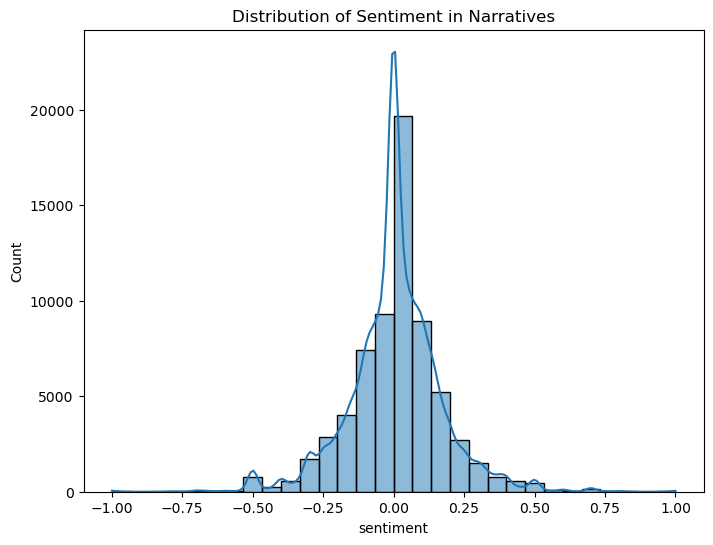

In [10]:
# use textblob to calculate sentiment
data['sentiment'] = data['narrative_prep'].apply(lambda x: TextBlob(x).sentiment.polarity)

# plot sentiment distribution
plt.figure(figsize=(8,6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment in Narratives')
plt.show()

The calculated sentiment score ranges from -1 (negative), to 0 (neutral) and 1 (positive).

#### Sentiment-Analyse by products:

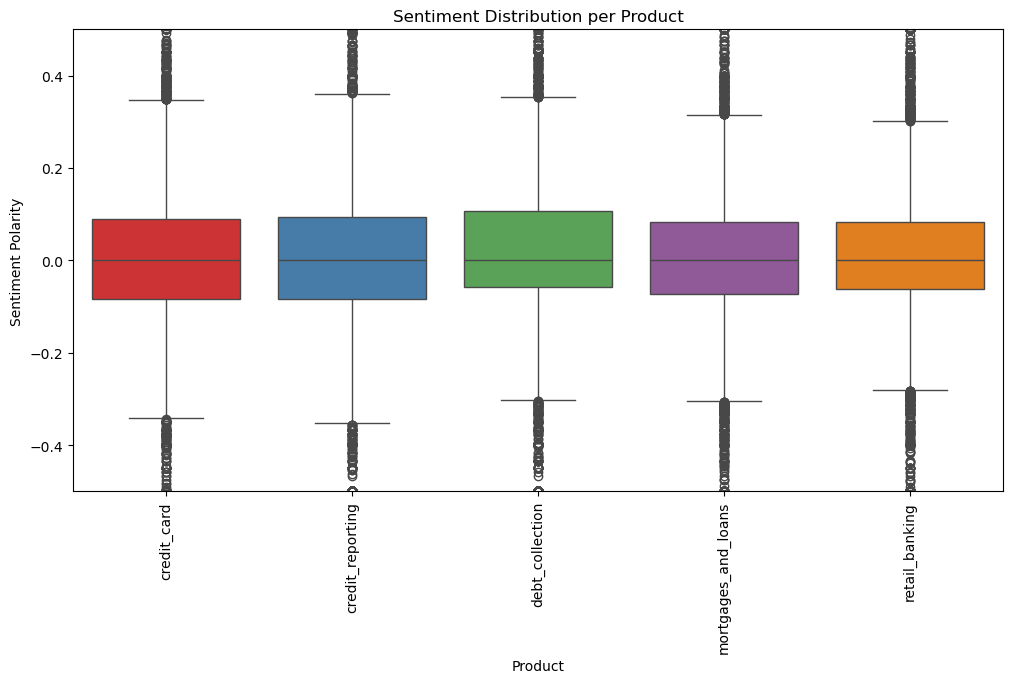

In [11]:
## show sentiment distribution per product as boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='product', y='sentiment', palette='Set1')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title('Sentiment Distribution per Product')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Product')
plt.show()

In [12]:
## save data from eda
data.to_csv('data/small_data_eda.zip', index=False, compression='zip')